In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data import *
from utils import *
from NMF import *
import pandas as pd
import seaborn # For nice plots
from copy import deepcopy
import warnings
import time
warnings.filterwarnings("ignore")

Implementation details
---

Handling of data is done in data.py. Tensorflow/keras is used to load data. As long as these packages are installed, the experiments here should be replicated on any computer.

In [2]:
"""
Load image data.
"""

np.random.seed(0)
mnist = MNIST()

# Digits to be used
Ms = [0,1]
M = len(Ms)

# Amount of data used
N_sup = 2500
N_sup_test = 0

mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)

V_sup = np.copy(mnist.x_sup_train.reshape((mnist.N_sup, 784)).T)
U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
U_sup = []
U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)
U_test_fit = []
for i in range(M):
    U_sup.append(U_s[:,i,:])
    U_test_fit.append(U_test[:,i,:])
V_test = np.copy(mnist.x_sup_test[:,:,:].reshape((mnist.N_sup_test, 784)).T)

2024-03-25 22:45:45.603803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Paper Figures
---


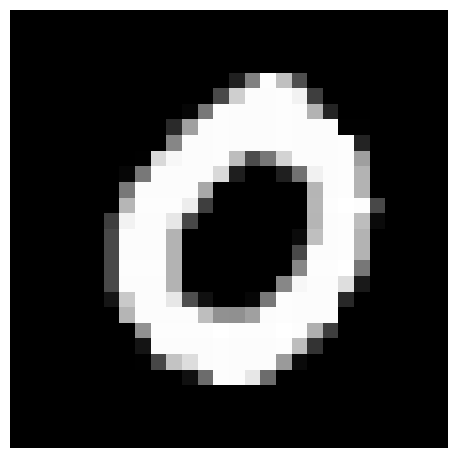

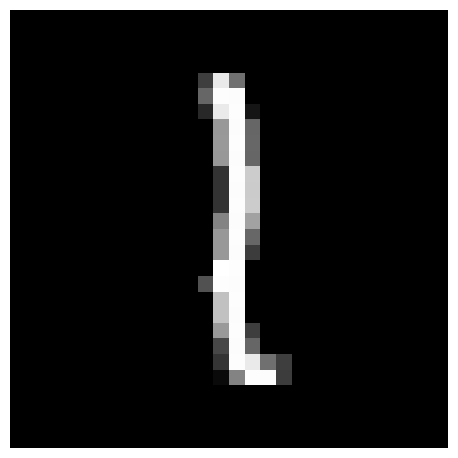

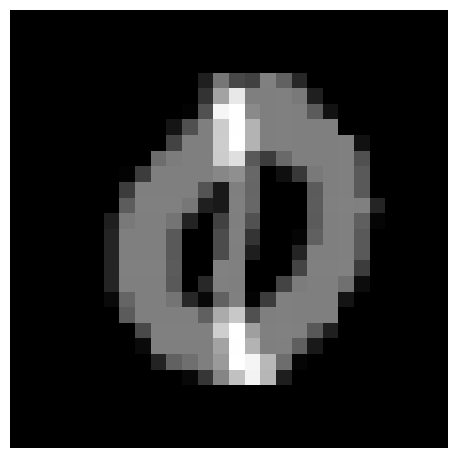

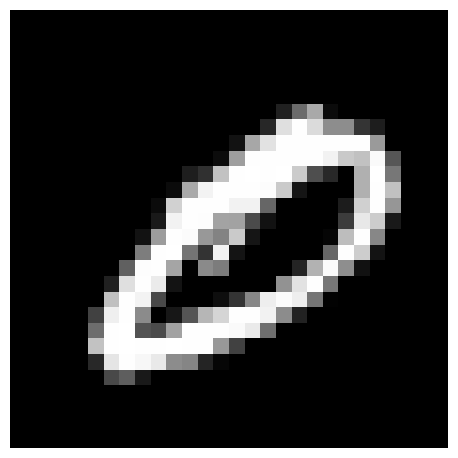

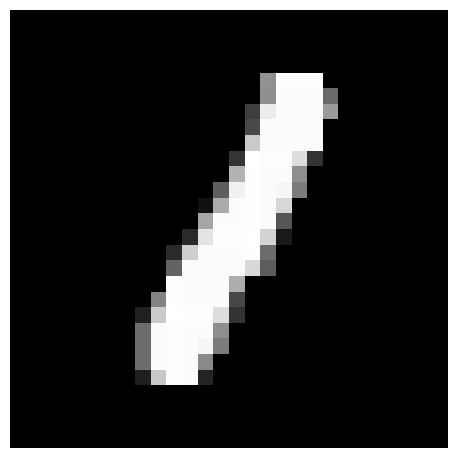

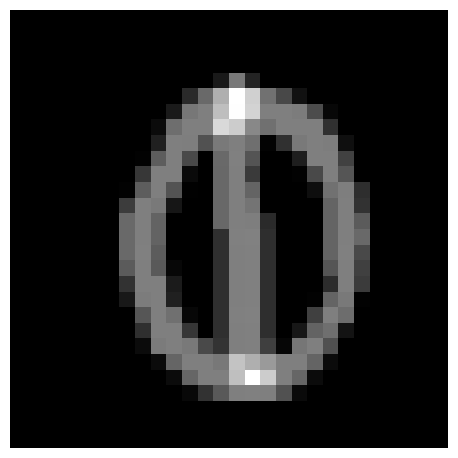

In [5]:
# Plot some example data
plt.imshow(mnist.y_sup_train[0,0], cmap = "gray")
plt.axis('off')
plt.tight_layout()
plt.savefig('mnist0strong.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(mnist.y_sup_train[0,1], cmap = "gray")
plt.axis('off')
plt.tight_layout()
plt.savefig('mnist1strong.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(mnist.x_sup_train[0], cmap = "gray")
plt.axis('off')
plt.tight_layout()
plt.savefig('mnistmixstrong.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(mnist.y_sup_train[1,0], cmap = "gray")
plt.axis('off')
plt.tight_layout()
plt.savefig('mnist0weak.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(mnist.y_sup_train[3,1], cmap = "gray")
plt.axis('off')
plt.tight_layout()
plt.savefig('mnist1weak.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(mnist.x_sup_train[2], cmap = "gray")
plt.axis('off')
plt.tight_layout()
plt.savefig('mnistmixweak.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

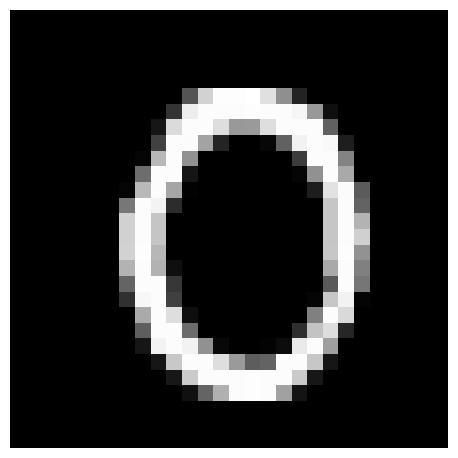

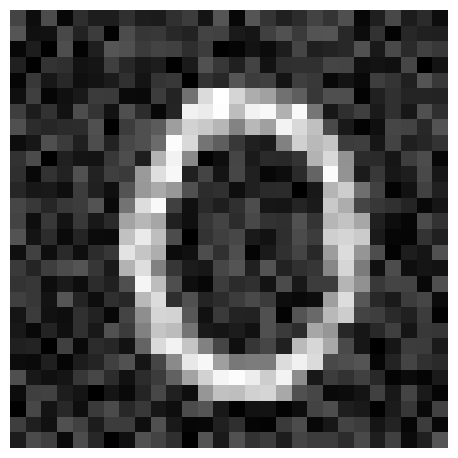

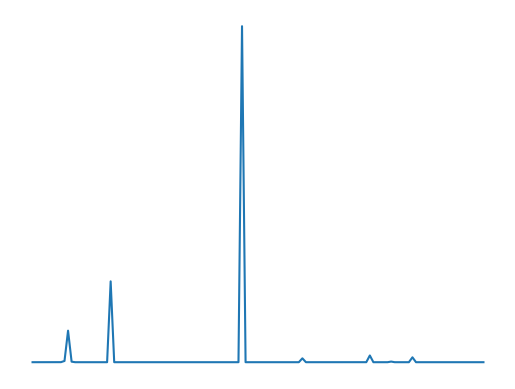

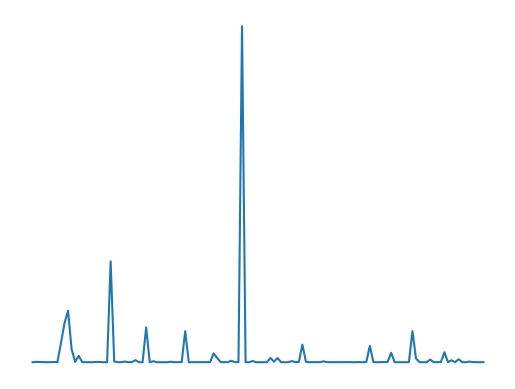

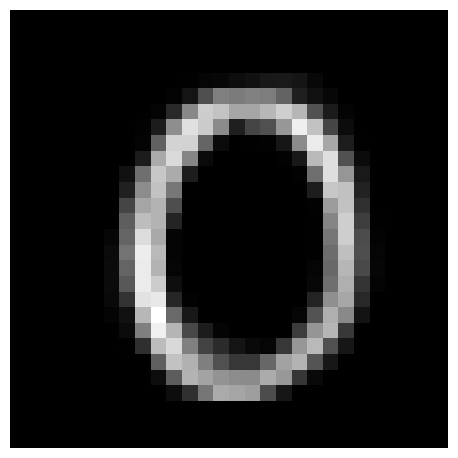

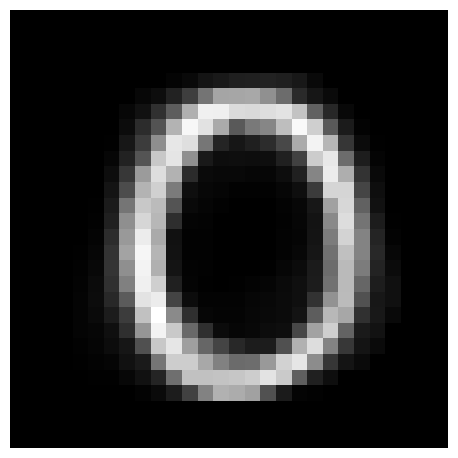

In [8]:
# Create example for figure

nmf = NMF(d = 128, epochs = 300, test_epochs = 100, batch_size = 500, mu_W = 1e-10, mu_H = 1e-0, normalize = True, update_H = False)
nmf.fit_std(U = U_sup[0])


u = mnist.y_sup_train[2,0] 
v= mnist.y_sup_train[2,0] + np.random.uniform(0.0,0.25, (28,28))
plt.imshow(u, cmap = "gray")
plt.axis('off')
plt.tight_layout()
plt.savefig('mnist0strongclean.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(v, cmap = "gray")
plt.axis('off')
plt.tight_layout()
plt.savefig('mnist0strongnoisy.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

h_u = nmf.transform(u.reshape(784,1))
h_v = nmf.transform(v.reshape(784,1))
plt.plot(h_u)
plt.axis('off')
plt.savefig('h_clean.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

plt.plot(h_v)
plt.axis('off')
plt.savefig('h_noisy.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

u_reconst = (np.minimum(1.0,nmf.W @ h_u)).reshape((28,28))
plt.imshow(u_reconst, cmap = "gray")
plt.axis('off')
plt.tight_layout()
plt.savefig('mnist0strong_reconst_clean.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
u_reconst = (np.minimum(1.0,nmf.W @ h_v)).reshape((28,28))
plt.imshow(u_reconst, cmap = "gray")
plt.axis('off')
plt.tight_layout()
plt.savefig('mnist0strong_reconst_noisy.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Convergence Experiment
---

In [3]:
# Convergence of NMF 
np.random.seed(0)
plt.rcParams.update({'font.size': 14})

batch_size = [50,500,1000,2500]
linestyles = ['dashdot']*10
times = []
loss_stds = []
for i,b in enumerate(batch_size):
    tick = time.time()
    nmf = NMF(d = 64, epochs = 300, batch_size = b, mu_W = 1e-10, mu_H = 1e-10, normalize = True, update_H = False)
    loss_stds.append(nmf.fit_std(U = U_sup[0],conv = True))
    tock = time.time()
    times.append(tock-tick)
print(times)

[17.528636932373047, 13.256484031677246, 17.36546277999878, 11.924896001815796]


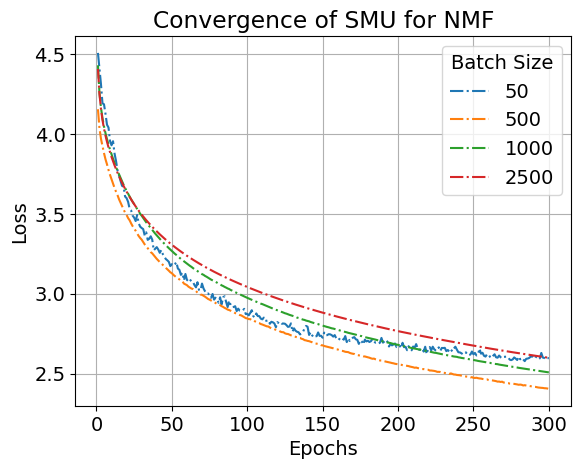

In [4]:
# Plotting
for i,b in enumerate(batch_size): 
    plt.plot(np.arange(1,len(loss_stds[i])), loss_stds[i][1:],label = f"{b}", linestyle = linestyles[i])
plt.legend(title = "Batch Size", loc = "upper right")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title(f"Convergence of SMU for NMF")
plt.grid()
plt.savefig("fig/std_conv.png")
plt.show()

In [3]:
# Convergence of Adversarial NMF
plt.rcParams.update({'font.size': 14}) 
np.random.seed(0)

batch_size = [250,500,1000,2500]
batch_size_adv = [100,250,500,2500]
linestyles = ['dashdot']*10
times = []
loss_advs = []

for i,b in enumerate(batch_size):
    tick = time.time()
    nmf_sep = NMF_separation(ds = [64,64], epochs =300, prob = "adv", true_sample = "std", normalize = True, update_H = False,
        mu_W = 1e-10, mu_H = [1e-10]*2, batch_size = batch_size[i], batch_size_adv = batch_size_adv[i], tau_A = 0.1)
    U_adv = nmf_sep.create_adversarial(U_sup, V_sup)
    nmf_sep.NMFs[0].omega = nmf_sep.omegas[0]
    loss_advs.append(nmf_sep.NMFs[0].fit_adv(U = U_sup[0], U_adv = U_adv[0], conv = True))

    tock = time.time()
    times.append(tock-tick)
print(times)


[42.23488998413086, 39.59247899055481, 29.77217411994934, 31.65937089920044]


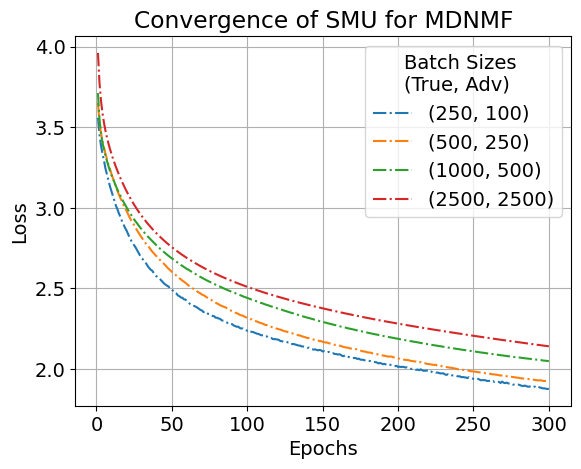

In [5]:
# Plotting
for i, b in enumerate(batch_size): 
    plt.plot(np.arange(1,len(loss_advs[i])), loss_advs[i][1:],label = f"({b}, {batch_size_adv[i]})", linestyle = linestyles[i])
plt.legend(title = r"Batch Sizes " + "\n" + "(True, Adv)")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convergence of SMU for MDNMF")
plt.grid()
plt.savefig("fig/adv_conv.png")
plt.show()


In [6]:
# Convergence of discriminative NMF
np.random.seed(1)
plt.rcParams.update({'font.size': 14}) 

batch_size_sup = [50,500,1000,2500]
linestyles = ['dashdot']*10
ds = [64,64]
times = []
loss_sups = []
for i,b in enumerate(batch_size_sup):
    tick = time.time()
    nmf = NMF(d = np.sum(ds), ds = ds, epochs = 300, mu_W = 1e-10, mu_H = 1e-10, warm_start_epochs = 10,batch_size_sup = b, normalize = True)
    loss_sups.append(nmf.fit_sup(U_sup = U_sup, V_sup = V_sup, conv = True))
    tock = time.time()
    times.append(tock-tick)
print(times)

[77.03912901878357, 28.94983696937561, 22.795959949493408, 24.169471979141235]


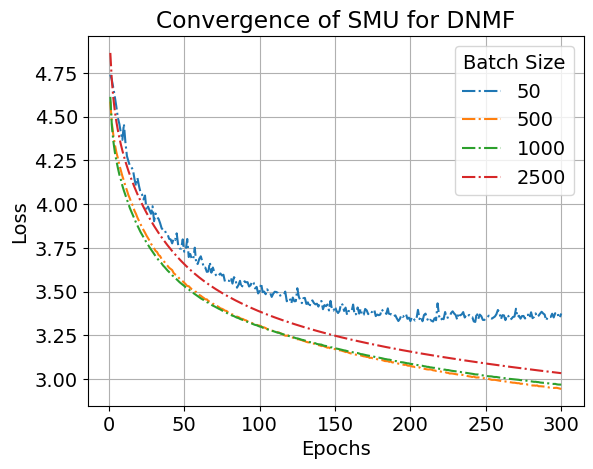

In [7]:
# Plotting
for i, b in enumerate(batch_size_sup):
    plt.plot(np.arange(1,len(loss_sups[i][0])),loss_sups[i][0,1:],label = f"{b}", linestyle = linestyles[i])
plt.legend(title = "Batch Size", loc = "upper right")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convergence of SMU for DNMF")
plt.grid()
plt.savefig("fig/sup_conv.png")
plt.show()

In [3]:
# Convergence of D+ANMF
plt.rcParams.update({'font.size': 14}) 
np.random.seed(0)

batch_size = [100,500,1000,2500]
batch_size_adv = [100, 500, 250, 5000]
batch_size_sup = [100, 500, 1000, 2500]
linestyles = ['dashdot']*10
times = []
loss_fulls = []
for i,b in enumerate(batch_size):
    tick = time.time()
    nmf_sep = NMF_separation(ds = [64,64], epochs = 300, mu_W = 1e-10, mu_H = [1e-10]*2, prob = "full", init = "exem",
        batch_size = batch_size[i], batch_size_adv = batch_size_adv[i], batch_size_sup = batch_size_sup[i], tau_W = 0.5, tau_A = 0.1, tau_S = 0.5,
        true_sample = "sup")
    U_adv = nmf_sep.create_adversarial(U_sup, V_sup)
    nmf_sep.NMF_concat.omegas = nmf_sep.omegas
    loss_fulls.append(nmf_sep.NMF_concat.fit_full(U = U_sup, U_adv = U_adv, U_sup = U_sup, V_sup = V_sup, conv = True))
    tock = time.time()
    times.append(tock-tick)
print(times)
    

[135.1918818950653, 94.62924599647522, 96.75642108917236, 98.62972402572632]


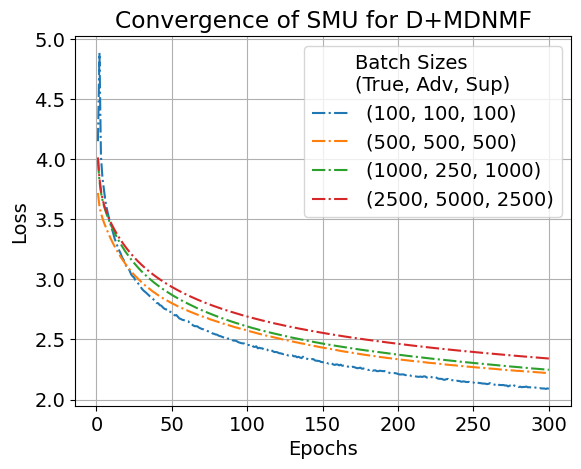

In [4]:
# Plotting
for i, b in enumerate(batch_size):
    plt.plot(np.arange(1,len(loss_fulls[i][0])),loss_fulls[i][0,1:],label = f"({b}, {batch_size_adv[i]}, {batch_size_sup[i]})", linestyle = linestyles[i])
plt.legend(title = "Batch Sizes" + '\n' + "(True, Adv, Sup)")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convergence of SMU for D+MDNMF")
plt.grid()
plt.savefig("fig/full_conv.png")
plt.show()

The proposed methods converge in the sense that the epochs reduce the loss we are minimizing. The results imply that selecting smaller batch sizes
can lead to faster convergence, at the cost of random fluctuations, particularly for very small batch sizes. We also observe that the batch size of the adversarial term can safely be chosen small without harming convergence speed, likely because $\tau_A$ is small as well.

Data rich experiment
---


In this experiment we want to test the proposed methods in a setting where we have a lot of strong supervised data to see how the data settings compare. We test this on $0$ and $1$ digits, as NMF performs relatively well in this situation. We select $N_0 = N_1 = 5000$ data of each source and $N_\text{test} = 1000$ test data.
We use the sparsity parameters $\mu_H = 10^{-2}$ and $\mu_W = 10^{-10}$.
This is because we are working with relatively low $d$, so each atom of the dictionary is required to fully
reconstruct data. 

We use $100$ training epochs, and $100$ test epochs.
Using more training epochs can be slightly beneficial for ANMF in experiments,
but it is actually detrimental to the performance of standard NMF.
We observe that using few training epochs has a regularizing effect, and can lead to much better results
for source separation. 
For ANMF we use $\tau_A = 0.2$. 
We use both data from other sources and mixed data as adversarial data, which means that $\hat{N}_0 = \hat{N}_1 = 10000$.
Moreover, we choose the parameter $\beta$ as outlined in the paper.

The batch sizes are selected as $(1000,500,1000)$ for the true, adversarial and supervised data, respectively.
We use the bases from standard NMF as warm start for MDNMF and DNMF, with the idea that MDNMF and DNMF can be used
to tune an already trained model to more specific data. We repeat the experiment on the same data for different numbers of basis vectors $d$, that we select to be the same for both sources. 

In [4]:
# Parameters for experiment
np.random.seed(1)
number_of_experiments = 1
M = 2
Ms_all = [0,1]
N_sup = 5000
N_sup_test = 1000
mu_W = 1e-10
mu_H = 1e-2

epochs = 200
test_epochs = 200
batch_size = 1000
batch_size_sup = 1000
batch_size_adv = 500
wiener = True

Ds = [16,32,64,128,256,512]

probs = ["std", "adv","sup","exem"]

df = pd.DataFrame(columns = ["id", "d", "prob", "mean_psnrs"])

taus = [0.0,0.2,0.0,0.0]

for ex in range(number_of_experiments):
    Ms = np.random.choice(Ms_all, M, replace = False)

    # Generate data
    mnist = MNIST()

    mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)
    V_sup = np.copy(mnist.x_sup_train[:,:,:].reshape((mnist.N_sup, 784)).T)
    U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
    U_sup = []
    for i in range(M):
        U_sup.append(U_s[:,i,:])

    V_test = np.copy(mnist.x_sup_test[:,:,:].reshape((mnist.N_sup_test, 784)).T)
    U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)

    # arrays to store results
    # Each problem, each source, each data
    psnrs = np.zeros((len(probs), M, len(Ds), N_sup_test)) 
  
    seps = []
    for j,d in enumerate(Ds):
        print("Running experiment with d = ", d)
        for i, prob in enumerate(probs):

            # Fit
            sep = NMF_separation(ds = [d] * M, tau_A = taus[i], normalize = True, update_H = False, true_sample = "std",
                epochs = epochs,prob = prob, 
                mu_W = mu_W, mu_H = mu_H, test_epochs = test_epochs, wiener = True,
                batch_size = batch_size, batch_size_adv = batch_size_adv, batch_size_sup = batch_size_sup)

            # Use standard NMF as initial conditions
            if prob == "adv" or prob == "sup":
                for k in range(M):
                    sep.NMFs[k].W = np.copy(stdWs[k])

            if prob == "std" or prob == "exem" or prob == "adv": 
                sep.fit(U = U_sup, V = V_sup)
            else:
                sep.fit(U_sup = U_sup, V_sup = V_sup)

            if prob == "std":
                stdWs = []
                for k in range(M):
                    stdWs.append(sep.NMFs[k].W)

            # Separate
            out = sep.separate(V_test)

            # Measure quality SHOULD USE eval member function of sep
            psnrs[i,:,j,:] = PSNR(U_test,out)

            df = pd.concat([df, pd.DataFrame({"d": [d]*N_sup_test, "id": np.arange(0,N_sup_test), "prob": [prob]*N_sup_test, "mean_psnrs": np.mean(psnrs[i,:,j,:],axis = 0)})])
            seps.append(deepcopy(sep))


Running experiment with d =  16
Running experiment with d =  32
Running experiment with d =  64
Running experiment with d =  128
Running experiment with d =  256
Running experiment with d =  512


In [5]:
df.to_csv('csv/data_rich.csv')

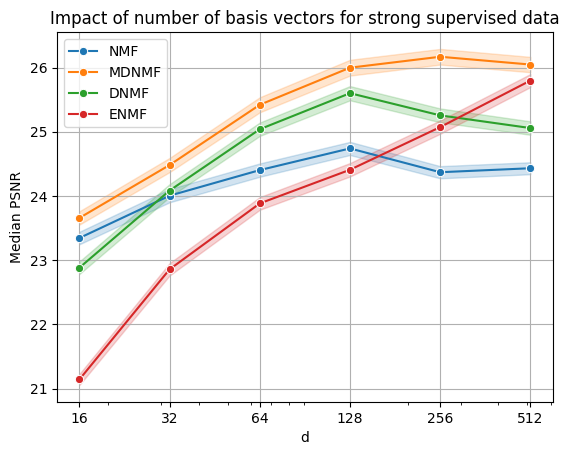

In [6]:
# Plotting
Ds = [16,32,64,128,256,512]
data_rich_df = pd.read_csv('csv/data_rich.csv', index_col = 0)
plt.rcParams.update({'font.size': 10}) 
plot = seaborn.lineplot(data_rich_df, x = "d", y = "mean_psnrs", hue = "prob", 
    estimator = "median", errorbar = "se", markers = True, dashes = True ,
    marker = 'o',legend=False)

plot.set(xscale='log', xticks = Ds, xticklabels = Ds)
plt.grid()
plt.ylabel("Median PSNR")
plt.legend(labels = ["NMF", "_nolegend_" , "MDNMF", "_nolegend_", "DNMF", "_nolegend_", "ENMF"])
plt.title("Impact of number of basis vectors for strong supervised data")
#plt.savefig("fig/Data_rich.pdf")
plt.show()

Data rich - Specific example
---

We now plot a specific data point.

In [7]:
# Pick trained model corresponding to a certain amount of basis vectors 
seps_ = seps[12:16]
for sep in seps_:
    sep.wiener = True
    print(sep.prob, sep.ds)

# Calculate aggregated PSNR
psnrs_std = seps_[0].eval(U_test[:,:,:], V_test, "psnr" , axis = 0)
psnrs_adv = seps_[1].eval(U_test[:,:,:], V_test, "psnr" , axis = 0)
psnrs_sup = seps_[2].eval(U_test[:,:,:], V_test, "psnr" , axis = 0)
psnrs_exem = seps_[3].eval(U_test[:,:,:], V_test, "psnr", axis = 0)


out_std = seps_[0].separate(V_test[:,:])
out_adv = seps_[1].separate(V_test[:,:])
out_sup = seps_[2].separate(V_test[:,:])
out_exem = seps_[3].separate(V_test[:,:])

diff_adv = psnrs_adv - psnrs_std

ids = np.argsort(diff_adv)

# Calculate PSNR for each source
psnrs_std = seps_[0].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)
psnrs_adv = seps_[1].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)
psnrs_sup = seps_[2].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)
psnrs_exem = seps_[3].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)




std [128, 128]
adv [128, 128]
sup [128, 128]
exem [128, 128]


MIX


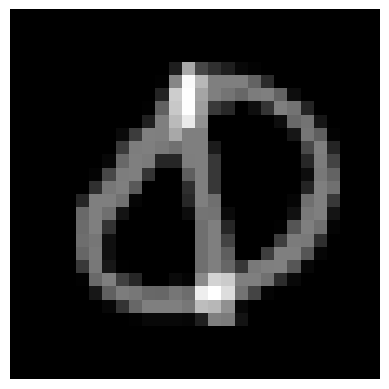

TRUE


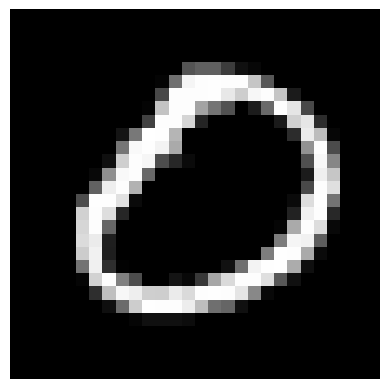

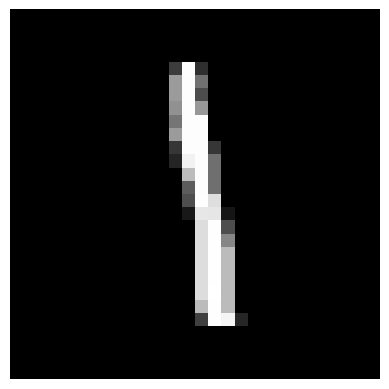

NMF


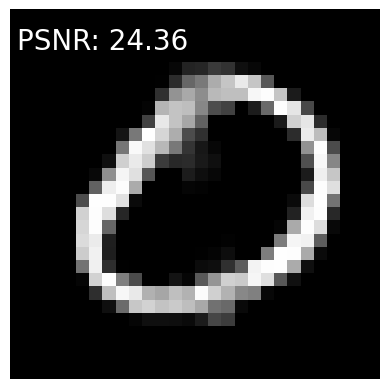

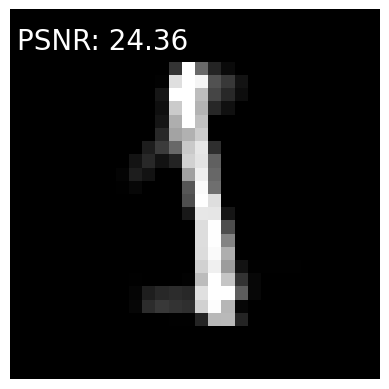

ANMF


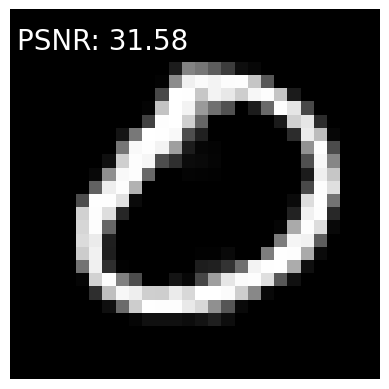

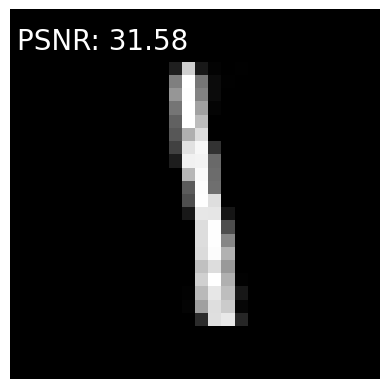

DNMF


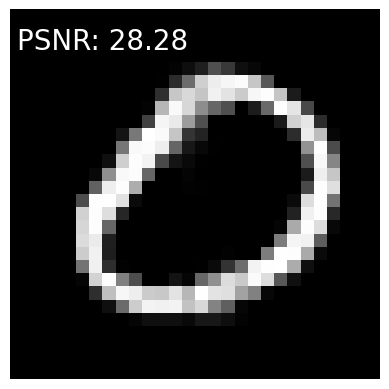

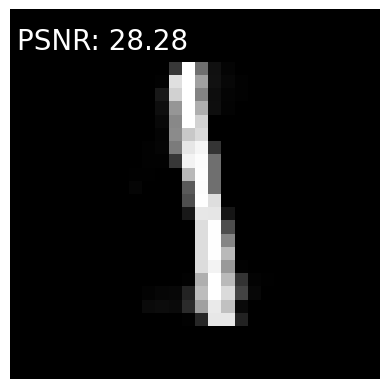

ENMF


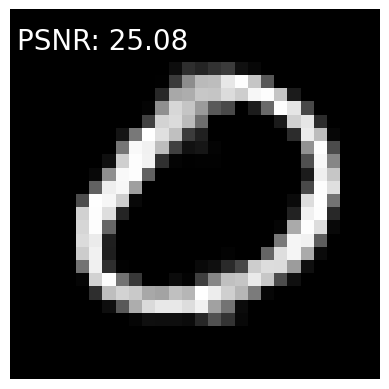

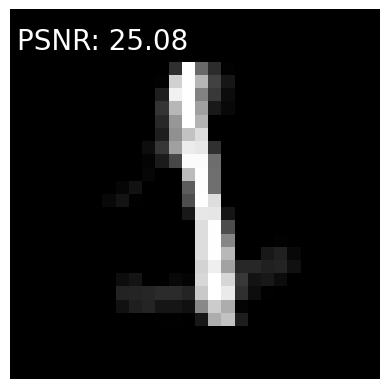

In [8]:
# Select id where adversarial outperforms standard NMF.
# Who needs for loops?

id = ids[-1]
vmin = 0
vmax = 0.5

print("MIX")
plt.imshow(V_test[:,id].reshape((28,28)), cmap = "gray", vmin = vmin)
plt.axis('off')
plt.savefig('fig/v.png', bbox_inches = "tight")
plt.show()

print("TRUE")
plt.imshow(U_test[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
plt.axis('off')
plt.savefig('fig/u0.png', bbox_inches = "tight")
plt.show()

plt.imshow(U_test[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
plt.axis('off')
plt.savefig('fig/u1.png', bbox_inches = "tight")
plt.show()

print("NMF")

fig, ax = plt.subplots()
ax.imshow(out_std[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin, vmax = vmax)
ax.axis('off')
plt.savefig('fig/u1_std.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_std[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_std_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_std[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin, vmax = vmax)
ax.axis('off')
plt.savefig('fig/u0_std.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_std[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_std_psnr.png', bbox_inches = "tight")
plt.show()

print("ANMF")

fig, ax = plt.subplots()
ax.imshow(out_adv[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin, vmax = vmax)
ax.axis('off')
plt.savefig('fig/u1_adv.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_adv[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_adv_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_adv[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin, vmax = vmax)
ax.axis('off')
plt.savefig('fig/u0_adv.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_adv[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_adv_psnr.png', bbox_inches = "tight")
plt.show()

print("DNMF")

fig, ax = plt.subplots()
ax.imshow(out_sup[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin, vmax = vmax)
ax.axis('off')
plt.savefig('fig/u1_sup.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_sup[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_sup_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_sup[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin, vmax = vmax)
ax.axis('off')
plt.savefig('fig/u0_sup.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_sup[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_sup_psnr.png', bbox_inches = "tight")
plt.show()

print("ENMF")

fig, ax = plt.subplots()
ax.imshow(out_exem[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin, vmax = vmax)
ax.axis('off')
plt.savefig('fig/u1_exem.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_exem[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_exem_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_exem[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin, vmax = vmax)
ax.axis('off')
plt.savefig('fig/u1_exem.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_exem[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_exem_psnr.png', bbox_inches = "tight")
plt.show()

Data rich - Effect of $\tau_A$
---

We now run an equivalent experiment where we try several values of $\tau_A$. We here use larger batch sizes to stabilize the algorithm, as it can be unstable for large $\tau$.

In [9]:
np.random.seed(1)
number_of_experiments = 1
M = 2
Ms_all = [0,1]
N_adv = 1000
N_sup = 5000
N_sup_test = 1000
mu_W = 1e-10
mu_H = 1e-2

epochs_std = 200
epochs = 200
test_epochs = 100
batch_size = 1000
batch_size_sup = 1000
batch_size_adv = 500
wiener = True

Ds = [32,64,128,256]

probs = ["std", "adv","adv","adv", "adv", "adv", "adv"]

df = pd.DataFrame(columns = ["id", "d", "prob", "tau", "mean_psnrs"])

taus = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5]

for ex in range(number_of_experiments):
    Ms = np.random.choice(Ms_all, M, replace = False)

    # Generate data
    mnist = MNIST()

    mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)
    V_sup = np.copy(mnist.x_sup_train.reshape((mnist.N_sup, 784)).T)
    U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
    U_sup = []
    for i in range(M):
        U_sup.append(U_s[:,i,:])

    V_test = np.copy(mnist.x_sup_test.reshape((mnist.N_sup_test, 784)).T)
    U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)

    # arrays to store results
    psnrs = np.zeros((len(probs), M, len(Ds), N_sup_test)) 

    for j,d in enumerate(Ds):
        print("Running experiment with d = ", d)
        for i, prob in enumerate(probs):

            # Fit
            sep = NMF_separation(ds = [d] * M, tau_A = taus[i], normalize = True, update_H = False, true_sample = "std",
                epochs = epochs_std if prob == "std" else epochs,prob = prob, 
                mu_W = mu_W, mu_H = mu_H, test_epochs = test_epochs, wiener = True,
                batch_size = batch_size, batch_size_adv = batch_size_adv, batch_size_sup = batch_size_sup)

            # Use standard NMF as initial conditions
            if prob == "adv" or prob == "sup":
                for k in range(M):
                    sep.NMFs[k].W = np.copy(stdWs[k])
            
            sep.fit(U = U_sup, V = V_sup)

            if prob == "std":
                stdWs = []
                for k in range(M):
                    stdWs.append(sep.NMFs[k].W)

            # Separate
            out = sep.separate(V_test)

            # Measure quality SHOULD USE eval member function of sep
            psnrs[i,:,j,:] = PSNR(U_test,out)

            df = pd.concat([df, pd.DataFrame({"d": [d]*N_sup_test, "id": np.arange(0,N_sup_test), "prob": [prob]*N_sup_test, "tau": [taus[i]]*N_sup_test, "mean_psnrs": np.mean(psnrs[i,:,j,:],axis = 0)})])

df.to_csv('csv/data_rich_tau.csv')

Running experiment with d =  32
Running experiment with d =  64
Running experiment with d =  128
Running experiment with d =  256


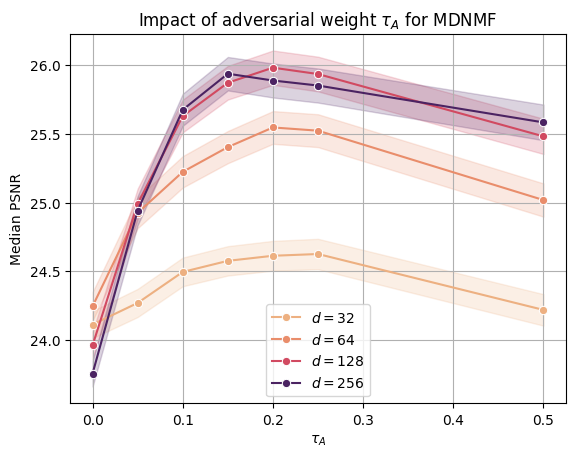

In [11]:
# Plotting
data_rich_tau_df = pd.read_csv('csv/data_rich_tau.csv', index_col = 0)
plt.rcParams.update({'font.size': 10}) 
seaborn.lineplot(data_rich_tau_df.drop(labels="id", axis = 1).dropna(), x = "tau", y = "mean_psnrs", hue = "d",
    estimator = "median", errorbar = "se", markers = True, dashes = True,
    marker = 'o',legend=False, palette = "flare")
plt.grid()
plt.ylabel("Median PSNR")
plt.legend(labels = [r"$d = 32$", "_nolegend_" , r"$d = 64$", "_nolegend_", r"$d = 128$", "_nolegend", r"$d = 256$"])
plt.title("Impact of adversarial weight " + r"$\tau_A$" + " for MDNMF")
plt.xlabel(r"$\tau_A$")
plt.savefig("fig/Data_rich_tau.pdf")
plt.show()

We observe that there is a relatively large range of $\tau_A$ values that yield good results, while selecting it too large yields very poor results. Higher model complexity means that there is more flexibility to both learn how to represent true data and not represent adversarial data. This is reflected in the result, as $d = 128$ has the highest difference between standard NMF ($\tau_A = 0$) and good values of $\tau_A$.

Data poor tuning experiment
---

We now do a larger tuning experiment where we have low amounts of data. We select $250$ strong supervised data and $500$ weak supervised data of each source. We mix each digit with a "one"-digit and use random search to find the best parameters for this specific setting.

The code shows what distributions were used for the different hyperparameters. These were chosen mostly to cover a large range of possible parameters, but also with some knowledge of what parameters are relevant for this problem.

In [2]:
np.random.seed(1)
number_of_experiments = 9
number_of_searches = 30
M = 2
Ms_all = [0,2,3,4,5,6,7,8,9]
N_adv = 500
N_V = 0
N_sup = 250
N_sup_test = 1000

# Distributions and parameters used
d_dict = {"name": 'ds', "dist": lambda: [64, 64]}
normalize_dict = {"name": 'normalize', "dist": lambda: np.random.choice([True,False], replace = True)}
mu_H_dict = {"name": 'mu_H', "dist": lambda: [np.power(10,np.random.uniform(-10,0))]*2}
mu_W_dict = {"name": 'mu_W', "dist": lambda: np.power(10,np.random.uniform(-10,-6))}
epochs_dict = {"name": 'epochs', "dist": lambda: np.random.randint(1,100)}
test_epochs_dict = {"name": 'test_epochs', "dist": lambda: np.random.randint(100,200)}
batch_size_dict = {"name": 'batch_size', "dist": lambda: np.random.choice([250,500], replace = True)}
batch_size_adv_dict = {"name": 'batch_size_adv', "dist": lambda: np.random.choice([125,250], replace = True)}
batch_size_sup_dict = {"name": 'batch_size_sup', "dist": lambda: np.random.choice([125], replace = True)}
true_sample_dict = {"name": 'true_sample', "dist": lambda: np.random.choice(["std", "sup"], replace = True)}
tau_A_dict = {"name": 'tau_W', "dist": lambda: np.random.uniform(0.25,1.0)}
tau_A_dict = {"name": 'tau_A', "dist": lambda: np.random.uniform(0.0,0.5)}
tau_S_dict = {"name": 'tau_S', "dist": lambda: np.random.uniform(0.0,0.75)}
betas_dict = {"name": 'betas', "dist": lambda: [np.random.uniform(0.5,1.2), np.random.uniform(0.5,1.2)]} 

probs = ["exem", "std", "adv", "sup", "full"]
results = {"M": [], "exem" : [], "std" : [], "adv" : [], "sup" : [], "full": []}

mnist = MNIST()

for i in range(number_of_experiments):
    print("Running experiment with integer ", i + (i>=1))

    Ms = [1,i + (i>=1)]
    results["M"].append(i + (i>=1))

    mnist.generate_adverserial(Ms = Ms, Ns = [N_adv]*M, N_V = N_V, type = "det", weights = [1.0/M]*M)
    U_r = []
    for i in range(M):
        U_r.append(np.copy(mnist.x_r_train[i][:,:,:].reshape((mnist.Ns_adv[i],784)).T))
    V = np.copy(mnist.x_v_train.reshape((mnist.N_adv_V,784)).T)
    
    mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)
    
    V_sup = np.copy(mnist.x_sup_train.reshape((mnist.N_sup, 784)).T)
    U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
    U_sup = []
    U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)
    U_test_fit = []
    for i in range(M):
        U_sup.append(U_s[:,i,:])
        U_test_fit.append(U_test[:,i,:])
    V_test = np.copy(mnist.x_sup_test.reshape((mnist.N_sup_test, 784)).T)


    for prob in probs:

        prob_dict = {"name": 'prob', "dist": lambda: prob}
        init_dict = {"name": 'init', "dist": lambda: 'exem' if prob != 'full' else 'rand'}

        if prob == "exem" or prob == "std":
            W_dict = {"name": 'Ws', "dist": lambda: None}

        param_dicts = [d_dict,
            normalize_dict,
            mu_H_dict, 
            prob_dict, 
            mu_W_dict, 
            epochs_dict, 
            test_epochs_dict,
            batch_size_dict, 
            batch_size_adv_dict, 
            batch_size_sup_dict,
            tau_A_dict,
            tau_S_dict,
            true_sample_dict,
            betas_dict,
            W_dict,
        ]

        rs = random_search(NMF_separation, param_dicts, N_ex = number_of_searches, 
            cv = 0 if prob != "full" and prob != "sup" else 2, source_aggregate = "mean", data_aggregate = "median")
        rs.fit(U = U_r, U_sup = U_sup, V_sup = V_sup, refit = True)

        results[prob].append(np.median(rs.best_model.eval(U_test[:,:,:],V_test[:,:], "psnr")))

        if prob == "std" or prob == "exem":
            Ws = [np.copy(rs.best_model.NMFs[0].W), np.copy(rs.best_model.NMFs[1].W)]
            W_dict = {"name": 'Ws', "dist": lambda : Ws}

data_poor_df = pd.DataFrame(results)
data_poor_df.to_csv('csv/data_poor_tuning.csv')

2024-03-26 00:14:11.171164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running experiment with integer  0
Running experiment with integer  2
Running experiment with integer  3
Running experiment with integer  4
Running experiment with integer  5
Running experiment with integer  6
Running experiment with integer  7
Running experiment with integer  8
Running experiment with integer  9


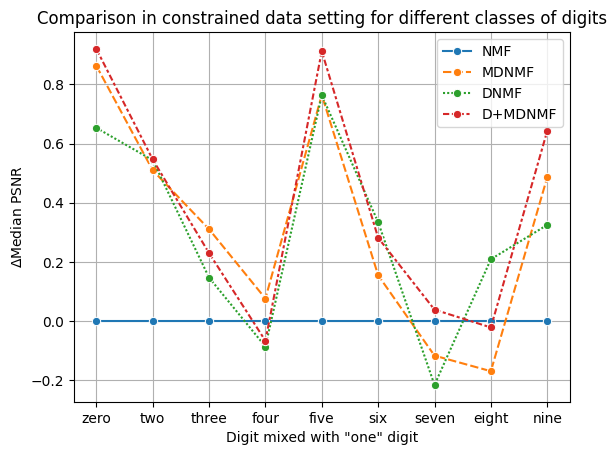

In [3]:
data_poor_df = pd.read_csv('csv/data_poor_tuning.csv', index_col = 0)

new_df = data_poor_df.copy(deep = True)
for column in new_df:
    if column != "M":
        new_df[column] = new_df[column] - data_poor_df["std"]
ax = seaborn.lineplot(data = new_df.drop("M", axis = 1).drop("exem", axis = 1), marker = 'o', errorbar = 'se')
ax.set_xticklabels(['','zero', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'])
ax.set_xlabel('Digit mixed with "one" digit')
ax.set_ylabel(r"$\Delta$" + "Median PSNR")
plt.title("Comparison in constrained data setting for different classes of digits")
plt.legend(labels = ["NMF", "_nolegend_", "MDNMF", "_nolegend_", "DNMF", "_nolegend_", "D+MDNMF"])
plt.grid()
plt.savefig('fig/data_poor.pdf')
plt.show()


The conclusion is that all methods have their advantages and disadvantages when it comes to computational complexity, performance,
difficulty of parameter selection and usability in different data settings. The results overall imply that methods that utilize more data
tend to perform better, and that adversarial fitting is a good idea for source separation problems. 